# Data Cleaning
##  Retrieving reviews¶

In [1]:
import os
import pandas as pd
import nltk
import numpy as np
import pandas as pd
import regex
import string
import unicodedata
import html
from html.parser import HTMLParser

from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment.util import  mark_negation
from nltk.tokenize import TweetTokenizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split

## Cleaning and Tokenizing
We need to build a preprocessor first tokenize the reviews.

In [2]:
class Preprocessor(BaseEstimator, TransformerMixin):


    def __init__(self, lower=True, strip=True, remove_punct=True, remove_diacritics=True, unicode_form='NFC', remove_stop=False, stem_tokens=False, lemmatize_tokens=True, language='english'):
        
        self.lower      = lower
        self.strip      = strip
        self.remove_punct = remove_punct
        self.remove_diacritics = remove_diacritics
        self.set_unicode_form(unicode_form)
     
        self.remove_stop = remove_stop
        self.stem_tokens = stem_tokens
        self.lemmatize_tokens = lemmatize_tokens    

        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.punct      = set(string.punctuation)

        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer(language) 
        self.tokenizer = TweetTokenizer()

 
    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]


    def fit(self, X, y=None):
        return self

 
    def set_stopwords(self, stopwords):
        self.stopwords  = stopwords or set(nltk.corpus.stopwords.words('english'))


    def set_punct(self, punct):
        self.punct      = punct or set(string.punctuation)


    def set_unicode_form(self, unicode_form):
        self.unicode_form = unicode_form.strip().upper()
        if not self.unicode_form in ['NFC','NFD','NFKC','NFKD']:
            self.unicode_form = 'NFC'


    def show_settings(self):
        print("lower: ",self.lower)
        print("strip: ",self.strip)
        print("remove_punct: ",self.remove_punct)
        print("remove_diacritics: ",self.remove_diacritics)
        print("unicode_form: ",self.unicode_form)
        print("remove_stop: ",self.remove_stop)
        print("stem_tokens: ",self.stem_tokens)
        print("lemmatize_tokens",self.lemmatize_tokens)       
        print("lemmatizer: ",type(self.lemmatizer).__name__)
        print("stemmer: ",type(self.stemmer).__name__) 
        print("punctuation: ",self.punct)
        print("stopwords: ",self.stopwords)


    # convert nltk pos-tag to wordnet pos-tag
    # for use by the wordnet lemmatizer
    @staticmethod
    def get_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('N'):
            return wn.NOUN
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:          
            return None

    # determine whether a string is comprised of all punctuation-like characters
    def is_punct(self, text):
        if text in self.punctuation:
            return True
        if regex.match(r"[\p{P}\p{Mn}\p{Sk}]+", text):
            return True
        return False


    # normalize token strings
    def normalize_string(self, token):

        token = html.unescape(token)
        token = token.lower() if self.lower else token
        token = token.strip(' _*')  if self.strip else token

        if self.remove_diacritics:
            token = regex.sub("\p{Mn}",'',unicodedata.normalize('NFD',token)) 

        #not is in the stopword list, but n't isn'
        if token == "n't" and self.stopwords:
            token = "not"
      
        return unicodedata.normalize(self.unicode_form,token)

    # determine whether a string is comprised completely
    # of things that seem like punctuation
    def is_punct(self, text):
        if text in string.punctuation:
            return True
        if regex.match(r"^[\p{P}\p{Mn}\p{Sk}]+$", text):
            return True
        return False

    # tokenize the document with optional normalization
    def tokenize(self, document, all_fields=False):
        tokens = []
        for sent in sent_tokenize(document):
            cleaner_sent = html.unescape(sent)
            for token in nltk.pos_tag(self.tokenizer.tokenize(cleaner_sent)):
                stem = ''
                token_text = self.normalize_string(token[0])
                token_pos = token[1]
                if self.remove_punct and self.is_punct(token_text):
                #if remove_punct and token_text in string.punctuation:
                    continue
                if self.remove_stop and token_text in self.stopwords:
                    continue
                if self.stem_tokens or all_fields:
                    stem = self.stemmer.stem(token_text)
                if self.lemmatize_tokens or all_fields:
                    wordnet_tag = self.get_wordnet_tag(token_pos)
                    if wordnet_tag is not None:
                        lemma = self.lemmatizer.lemmatize(token_text,wordnet_tag)
                    else:
                        lemma = token_text
                if all_fields:
                    tokens.append({'token': token_text, 'stem': stem, 'lemma': lemma})
                elif self.stem_tokens:
                    tokens.append(stem)
                elif self.lemmatize_tokens:
                    tokens.append(lemma)
                else:
                    tokens.append(token_text)     
        return tokens

# Deceptive Classifier Modeling

## Support Vector Machine (SVM)¶

In [3]:
mydf=pd.read_csv("./Hotel_reviews.csv")
X_data=mydf['Review']
y_labels=mydf['Authenticity']
X_data_train,X_data_test,y_labels_train,y_labels_test=train_test_split(X_data,y_labels,test_size=0.2,random_state=1)

In [4]:
# prepare labeled training and a test data

my_label_encoder = LabelEncoder()
y_labels_train = my_label_encoder.fit_transform(y_labels_train)
y_labels_test = my_label_encoder.fit_transform(y_labels_test)


print("Training data samples: ",len(X_data_train))
print("Training data labels: ",len(y_labels_train))
print("Test data samples: ",len(X_data_test))
print("Test data labels: ",len(y_labels_test))

Training data samples:  1280
Training data labels:  1280
Test data samples:  320
Test data labels:  320


In [5]:
import time
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC

In [6]:
def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg

def timeit(func):
    """
    Simple timing decorator
    """
    def wrapper(*args, **kwargs):
        start  = time.time()
        result = func(*args, **kwargs)
        delta  = time.time() - start
        return result, delta
    return wrapper

In [7]:
class VaderFeatureExtractor(BaseEstimator, TransformerMixin):
    """Takes in a corpus of tweets and calculates features using the Vader method"""

    def __init__(self):
        self.sid = SentimentIntensityAnalyzer()


    def vader_score(self,sentence):
        """ Calculates sentiment scores for a sentence using the Vader method """
        pol_scores = self.sid.polarity_scores(sentence)
        return(list(pol_scores.values()))

    def transform(self, X, y=None):
        """Applies vader_score on a data.frame containing tweets """
        values = []
        for tweet in X:
            values.append(self.vader_score(tweet))

        return(np.array(values))

    def fit(self, X, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self

In [8]:
@timeit
def build_model(X_data, y_labels, label_encoder, outpath=None, vectorizer="tfidf", classifier="svm"):
 
    # instantiate a preprocessor
    my_preprocessor = Preprocessor(remove_punct=True, remove_stop=True, lemmatize_tokens=True)

    # choose and instantiate a vectorizer
    if vectorizer == "count":
         my_vectorizer = CountVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)
    elif vectorizer == "tfidf":
        my_vectorizer = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)
    else:
        my_vectorizer = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)

    # choose and instantiate a classifier
    if classifier == "svm":
        my_classifier = SVC(kernel='linear')
    else:
        my_classifier = SVC(kernel='linear')
    
    # create a pipeline   
    model = Pipeline([
    ('preprocessor', my_preprocessor),
    ('vectorizer', my_vectorizer),
    ('classifier', my_classifier),
    ])

    # fit the model - calculae the best model parameters given the data
    model.fit(X_data, y_labels)

    # store the encoder that was used to prepare the labels
    # within the model object 
    model.labels_ = label_encoder
  

    # if the user has specified an output path, serialize this
    # model to a file
    if outpath:
        with open(outpath, 'wb') as f:
            pickle.dump(model, f)

        print("Model written out to {}".format(outpath))

    # return the model object
    return model


In [9]:
# get a short, understandable name for the pipeline step
# which can be steps such as preprocessor, vectorizer and tokenizer
def get_pretty_step_name(step_name):
    chop_spot = step_name.find("(")
    if chop_spot > 0:
        step_name = step_name[0:chop_spot]
    return step_name

In [10]:
# define a function for evaluating the model
@timeit
def evaluate_model(model, X_test_data, y_test_labels):
    vectorizer_name = get_pretty_step_name(str(model.named_steps['vectorizer']))
    classifier_name = get_pretty_step_name(str(model.named_steps['classifier']))
    print(vectorizer_name,"Vectorizer -->",classifier_name,"Model \nClassification Report:\n")
 
    y_predicted_labels = model.predict(X_test_data)
    print(clsr(y_test_labels, y_predicted_labels, target_names=model.labels_.classes_))

In [11]:
#count with svm
out_pickle = None
model,secs = build_model(X_data_train, y_labels_train, my_label_encoder, outpath=out_pickle, vectorizer="count", classifier="svm")
evaluate_model(model, X_data_test, y_labels_test)

CountVectorizer Vectorizer --> SVC Model 
Classification Report:

              precision    recall  f1-score   support

   deceptive       0.85      0.92      0.89       151
    truthful       0.92      0.86      0.89       169

    accuracy                           0.89       320
   macro avg       0.89      0.89      0.89       320
weighted avg       0.89      0.89      0.89       320



(None, 6.152634143829346)

In [12]:
#tfidf with svm
out_pickle = None
model,secs = build_model(X_data_train, y_labels_train, my_label_encoder, outpath=out_pickle, vectorizer="tfidf", classifier="svm")
evaluate_model(model, X_data_test, y_labels_test)

TfidfVectorizer Vectorizer --> SVC Model 
Classification Report:

              precision    recall  f1-score   support

   deceptive       0.87      0.92      0.90       151
    truthful       0.93      0.88      0.90       169

    accuracy                           0.90       320
   macro avg       0.90      0.90      0.90       320
weighted avg       0.90      0.90      0.90       320



(None, 6.609833240509033)

By comparing the macro-average of F-score in SVM models, Tfidf Vectorizer with SVC Model is the pipeline with the higher macro-average of F-score 0.90.

# Performance Evaluation and Analysis

## Best pipeline in Support Vector Machine (SVM)

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

In [15]:
mydf=pd.read_csv("./Hotel_reviews.csv")
X_data=mydf['Review']
y_labels=mydf['Authenticity']
X_data_train,X_data_test,y_labels_train,y_labels_test=train_test_split(X_data,y_labels,test_size=0.2,random_state=1)

In [16]:
# get the gold truth labels
y_labels_test_matrix = y_labels_test
X_data_test_matrix = X_data_test.tolist()

In [17]:
# get the predictions on the test data
svm_best_model, secs = build_model(X_data_train, y_labels_train, my_label_encoder, outpath=out_pickle, vectorizer="tfidf", classifier="svm")
yhat = svm_best_model.predict(X_data_test_matrix)
#y_pred = svm_best_model.labels_.inverse_transform(yhat)

Confusion matrix, without normalization
[[139  12]
 [ 20 149]]


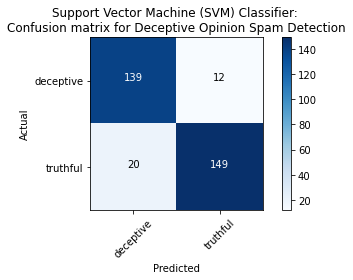

In [18]:
# generate the confusion matrix
cnf_matrix = confusion_matrix(y_labels_test_matrix, yhat,labels=['deceptive', 'truthful'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=['deceptive', 'truthful'], 
                      title='Support Vector Machine (SVM) Classifier: \nConfusion matrix for Deceptive Opinion Spam Detection')

In [19]:
evaluate_model(svm_best_model, X_data_test, y_labels_test)

TfidfVectorizer Vectorizer --> SVC Model 
Classification Report:

              precision    recall  f1-score   support

   deceptive       0.87      0.92      0.90       151
    truthful       0.93      0.88      0.90       169

    accuracy                           0.90       320
   macro avg       0.90      0.90      0.90       320
weighted avg       0.90      0.90      0.90       320



(None, 6.105400085449219)